# import
对于本章，我们将需要以下导入：

In [2]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, \
precision_recall_curve, auc

from stepbystep.v0 import StepByStep

ModuleNotFoundError: No module named 'stepbystep'

# 分类问题
我们现在将切换到处理称为分类问题的不同类别的问题。在分类问题中，我们试图预测数据点属于哪个类别。假设我们有两类点；它们要么是红色要么是蓝色。这些是点的标签 ( y )。果然，我们需要给它们赋数值。我们可以将 0 分配给红色，将 1 分配给蓝色。与零相关联的类是负类，而一对应于正类。简而言之，对于二进制分类，我们有：

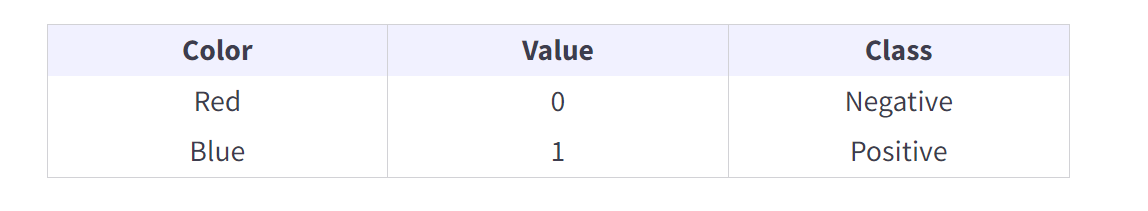

在分类模型中，输出是正类的预测概率。在我们的例子中，模型将预测一个点为蓝色的概率。选择哪个类别是正面的，哪个类别是负面的，不会影响模型性能。如果我们反转映射，使红色成为正类，唯一的区别将是模型会预测一个点为红色的概率。但是，由于两个概率之和必须为 1，我们可以轻松地在它们之间进行转换，因此模型是等价的。我们不是先定义模型然后为它生成合成数据，而是反过来做。

## 数据生成
这次让我们使用两个特征（x 1 和 x 2 ）使数据更有趣。我们将使用 Scikit-Learn 的 1 方法生成一个包含 100 个数据点的玩具数据集。我们还将添加一些高斯噪声，并设置随机种子以确保再现性。

In [1]:
from sklearn.datasets import make_moons

# using make_moons to generate 100 data points dataset
X, y = make_moons(n_samples=100, noise=0.3, random_state=0)
print(X.shape, y.shape)

(100, 2) (100,)


然后，为方便起见，我们将使用 Scikit-Learn 的 train_test_split 方法执行训练验证拆分。稍后我们将回到拆分索引：

In [3]:
# Performing train-validation split using train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=.2, 
    random_state=13
)
# Displaying the values of the training and validation sets (first five only)
print("Training:{} \n\nValidation:{}".format(X_train[:5], X_val[:5]))
# 以上代码使用了train_test_split函数，将原始数据集（X和y）分成训练集（X_train和y_train）和验证集（X_val和y_val）两部分。
# 其中，test_size=.2指定了验证集占原始数据集的20%；random_state=13是指定了一个随机数种子，以确保每次分割数据集的结果
# 都是相同的。
# 最后，代码打印出了训练集和验证集的前五个值，分别对应X_train和X_val。

Training:[[-0.0551441  -0.03733246]
 [ 0.82954503 -0.53932149]
 [ 1.66760217 -0.42485665]
 [-0.88230758  0.07249044]
 [-0.59702417  0.6572361 ]] 

Validation:[[ 0.18121142  0.24717743]
 [ 0.20718083 -0.09767143]
 [-0.87539365  0.50543423]
 [ 0.46730819  0.54703192]
 [-1.06964997  0.13666025]]


接下来，我们将使用 Scikit-Learn 的 StandardScaler 对特征进行标准化

In [4]:
# Standardizing the features using StandardScaler
sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

# Displaying the values of the training and validation sets after standardizing (first five only)
print("Training:{} \n\nValidation:{}".format(X_train[:5], X_val[:5]))
# 以上代码使用了StandardScaler函数来对原始数据集进行标准化处理，以确保不同特征之间的数值范围相同。
# 首先，使用fit函数对X_train进行了拟合，计算出每个特征的均值和标准差。然后，使用transform函数将X_train和X_val分别标准化，
# 使得它们的均值为0，方差为1。这里是对X_train和X_val进行相同的变换，以确保它们具有相同的比例和分布，避免模型对训练
# 和验证数据的处理方式不同而导致的偏差。

Training:[[-0.59635346 -0.51713419]
 [ 0.3937561  -1.35813138]
 [ 1.33167696 -1.16636502]
 [-1.52208256 -0.33314461]
 [-1.20280449  0.64649722]] 

Validation:[[-0.33183358 -0.04048629]
 [-0.30276963 -0.61822186]
 [-1.51434476  0.39217903]
 [-0.01164524  0.46186888]
 [-1.73174885 -0.22563902]]


请记住，您应该只使用训练集来拟合 StandardScaler ，然后使用它的 transform 方法将预处理步骤应用于所有数据集：训练、验证和测试。否则，您会将验证和/或测试集中的信息泄露给您的模型！

下图显示了生成的训练和验证数据

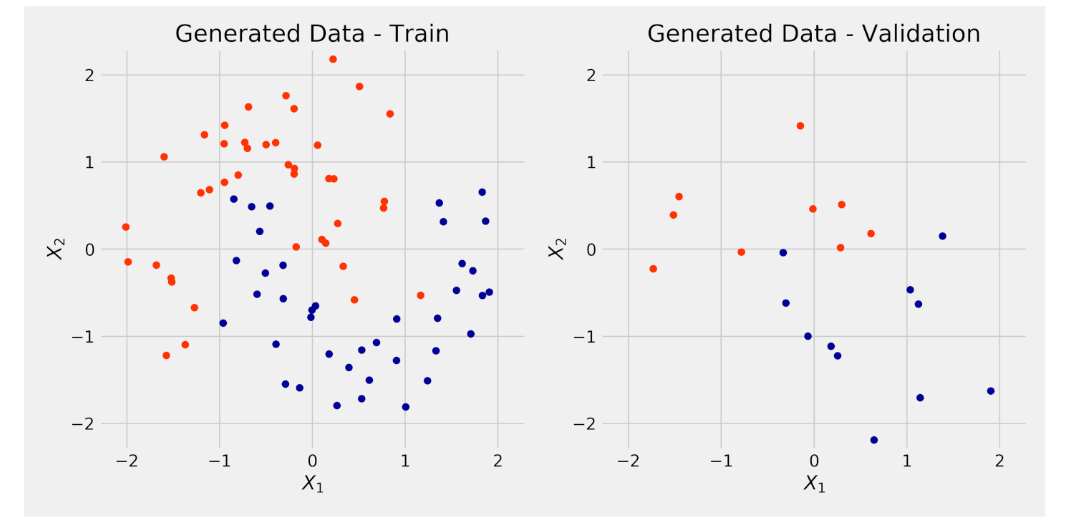

## 数据准备
希望您已经熟悉此步骤。像往常一样，数据准备步骤将 Numpy 数组转换为 PyTorch 张量，为它们构建 TensorDatasets，并创建相应的数据加载器。

In [5]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()#-1的意思是自动计算行数，1的意思是列数为1

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=16, 
    shuffle=True
)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)
# Displaying the corresponding training and validation dataloaders
print("{} \n\n{}".format(train_loader, val_loader))

我们的训练集中有 80 个数据点 ( N = 80 )。我们有 x 1 和 x 2 两个特征，标签 ( y ) 为零（红色）或一（蓝色）。我们有一个数据集，现在我们需要创建我们的模型。

# 分类问题模型
## Model
给定分类问题，最直接的模型之一是逻辑回归。但是，我们不是简单地展示它并立即使用它，而是要建立它。这种方法背后的基本原理是双重的。首先，它会阐明如果将此算法用于分类，为什么称为逻辑回归。其次，你会对什么是logit有一个清晰的认识。
## 线性回归 
好吧，既然它被称为“逻辑回归”，那么线性回归是我们构建它的一个很好的起点。具有两个特征的线性回归模型会是什么样子？

$\begin{aligned}y=b+w_1x_1+w_2x_2+\epsilon\end{aligned}$

上面的模型有一个明显的问题。我们的标签 ( y ) 是离散的，这意味着它们只能是零或一。我们需要稍微更改模型以使其适应我们的目的。

有道理，对吧？无论如何，我们已经称它们为正类和负类。为什么不好好利用他们的名字呢？我们的模型看起来像这样：

$ \begin{aligned}y=\left\{\begin{array}{cc}1,&\textit{if }b+w_1x_1+w_2x_2\geq0\\ 0,&\textit{if }b+w_1x_1+w_2x_2<0\end{array}\right.\end{aligned}$

下面是一个例子：

In [6]:
import numpy as np

# Variables initialized
b = -1
w1, w2 = 2, 3
N = 5

# Computing linear regression
np.random.seed(42)
x1 = x2 = np.random.rand(N, 1)
epsilon = (.1 * np.random.randn(N, 1))
y = b + (w1 * x1) + (w2 * x2) + epsilon

# Mapping linear regression model to labels
results = [1 if num >= 0 else 0 for num in y]

# Displaying the results
print("Values of y:")
print(y)
print("\nLabels:")
print(results)

Values of y:
[[ 0.90060472]
 [ 3.85462306]
 [ 2.6018819 ]
 [ 1.94077544]
 [-0.27704481]]

Labels:
[1, 1, 1, 1, 0]


## Logits
为了让我们的更轻松，让我们给上面等式的右边起一个名字：logit (z)。

$z=b+w_1x_1+w_2x_2$

上面的等式与原始线性回归模型惊人地相似，但我们将结果值称为“z”或“logit”，而不是 y 或“label”。下面是一个例子：

In [7]:
import numpy as np

# Variables initialized
b = -1
w1, w2 = 2, 3
N = 5

# Computing logits
np.random.seed(42)
x1 = x2 = np.random.rand(N, 1)
z = b + (w1 * x1) + (w2 * x2)

# Displaying the results
print("Values of z:")
print(z)

Values of z:
[[ 0.87270059]
 [ 3.75357153]
 [ 2.65996971]
 [ 1.99329242]
 [-0.2199068 ]]


“这是否意味着 logit 与线性回归相同？”不完全的。它们之间有一个根本区别；上面的 logit 方程中没有误差项 (epsilon)。
## 概率
如果数据点的 logit 等于零，则它恰好位于决策边界，因为它既不是正数也不是负数。为了完整起见，我们将其分配给正类，但这种分配具有最大的不确定性。因此，相应的概率需要为 0.5 (50%)，因为它可以任意选择。按照这种推理，我们希望将较大的正 logit 值分配给较高的概率（属于正类），将较大的负 logit 值分配给较低的概率（属于正类）。对于非常大的正负 logit 值 (z)，我们希望：

$ \begin{aligned}P(y=1)\approx1.0,ifz=>0\\ \\ P(y=1)=0.5,ifz=0\\ \\ P(y=1)\approx0.0,ifz<<0\end{aligned}$

我们仍然需要找出一个将 logit 值映射到概率的函数。我们很快就会到达那里。但首先，我们需要谈谈“比值比”。

优势比由成功概率 ( p ) 和失败概率 ( q ) 之间的比率给出:

$\quad oddsratio(p)=\dfrac{p}{q}=\dfrac{p}{1-p}$

在代码中，我们的 odds_ratio 函数如下所示：

In [8]:
def odds_ratio(prob):
    return prob / (1 - prob)

p = .75
q = 1 - p
print(odds_ratio(p), odds_ratio(q))

3.0 0.3333333333333333


## 对数比率
通过取比值比的对数，该函数不仅是对称的，而且还将概率映射为实数，而不仅仅是正数：

$ \begin{aligned}logoddsratio(p)=log(\dfrac{p}{1-p})\end{aligned} $

在代码中，我们的 log_odds_ratio 函数如下所示：

In [ ]:
def log_odds_ratio(prob):
    return np.log(odds_ratio(prob))

p = .75
q = 1 - p
print(log_odds_ratio(p), log_odds_ratio(q))

正如预期的那样，加起来为 100% 的概率（如 75% 和 25%）对应于绝对值相同的对数优势比。让我们绘制它：

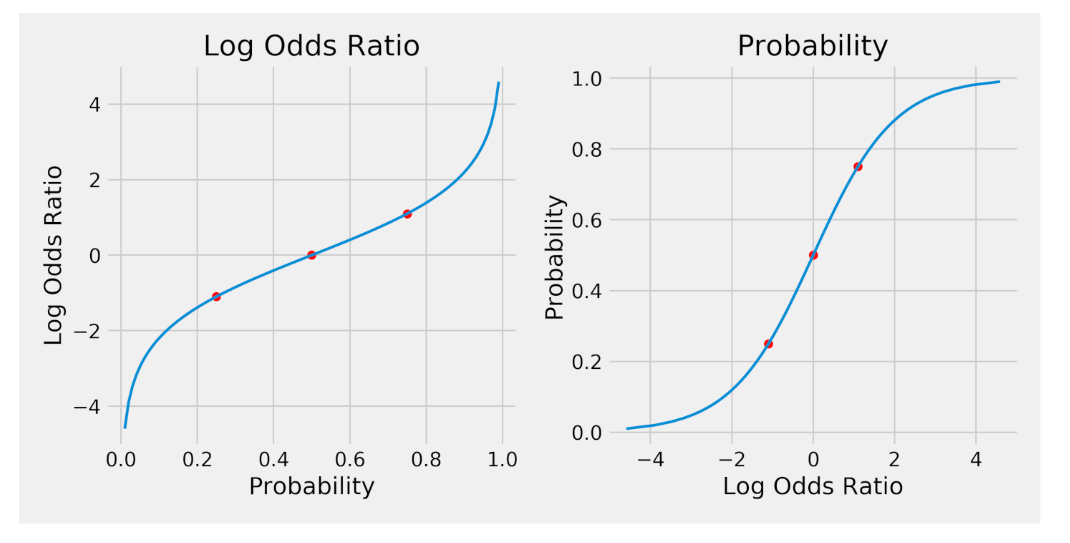

在左侧，每个概率映射到对数比值比。红点分别对应25%、50%、75%的概率，和之前一样。如果我们翻转水平轴和垂直轴（右图），我们正在反转函数，从而将每个对数比值比映射为概率。这正是我们正在寻找的功能！

# Sigmoid和逻辑回归
了解 sigmoid 如何在将 logit 值映射到概率中发挥联系及其在逻辑回归中的作用。我们正在尝试将 logit 值映射到概率中，并且我们以图形方式找到了将对数优势比映射到概率中的函数。显然，我们的对数是对数比值比。当然，得出这样的结论并不十分科学，但本练习的目的是说明回归结果（以对数 (z) 表示）如何映射到概率。所以，这就是我们到达的地方：

$ \begin{array}{rcl}b+w_1x_1+w_2x_2=z&=log(\dfrac{p}{1-p})\\\\ e^{b+w_1x_1+w_2x_2}=e^z=\dfrac{p}{1-p}\end{array}$

让我们稍微计算一下这个等式，反转、重新排列和简化一些项以分离$p$：

$\begin{aligned}&\frac{1}{e^z}=\frac{1-p}{p}\\\\ &e^{-z}=\frac{1}{p}-1\\\\ &1+e^{-z}=\frac{1}{p}\\\\ &p=\frac{1}{1+e^{-z}}\end{aligned}$

是不是很眼熟？那是一个 sigmoid 函数！它是对数比值比的倒数，具有以下等式：

$p=\sigma\big(z\big)=\dfrac{1}{1+e^{-z}}$

下面也给出了这方面的代码：

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

p = .75
q = 1 - p
print(sigmoid(log_odds_ratio(p)), sigmoid(log_odds_ratio(q)))

## Sigmoid
不过没有必要实现我们自己的 sigmoid 函数。 PyTorch 提供了两种不同的方式来使用 sigmoid：**torch.sigmoid 和 nn.Sigmoid** 。第一个是一个简单的函数，就像上面的那个。但相反，它需要一个张量作为输入并返回另一个张量：

In [9]:
import torch

print(torch.sigmoid(torch.tensor(1.0986)), torch.sigmoid(torch.tensor(-1.0986)))

tensor(0.7500) tensor(0.2500)


第二个是从 nn.Module 继承的完整类。就所有意图和目的而言，它本身就是一个模型。然而，它是一个非常简单明了的模型，因为它只实现了一个 forward 方法，该方法调用了 torch.sigmoid 。
## Sigmoid、非线性和激活函数 
sigmoid 函数是非线性的。它可用于将 logits 映射到概率，正如我们刚刚发现的那样。但这不是它的唯一目的！非线性函数在神经网络中起着基础性作用。我们通过通常的名称了解这些非线性：激活函数。sigmoid 是“受生物学启发”的，是过去使用的第一个激活函数。紧随其后的是双曲正切 (TanH)，最近又出现了整流线性单元 (ReLU) 及其衍生的一整套函数。

逻辑回归是一种模型，其中（给定 $x_1$和 $x_2$
的两个特征，模型将拟合线性回归，使其输出为 $logits (z)$，使用 sigmoid 函数将其转换为概率。这将有以下等式：

$ P(y=1)=\sigma(z)=\sigma(b+w_1x_1+w_2x_2)$

一图胜千言，让我们想象一下：

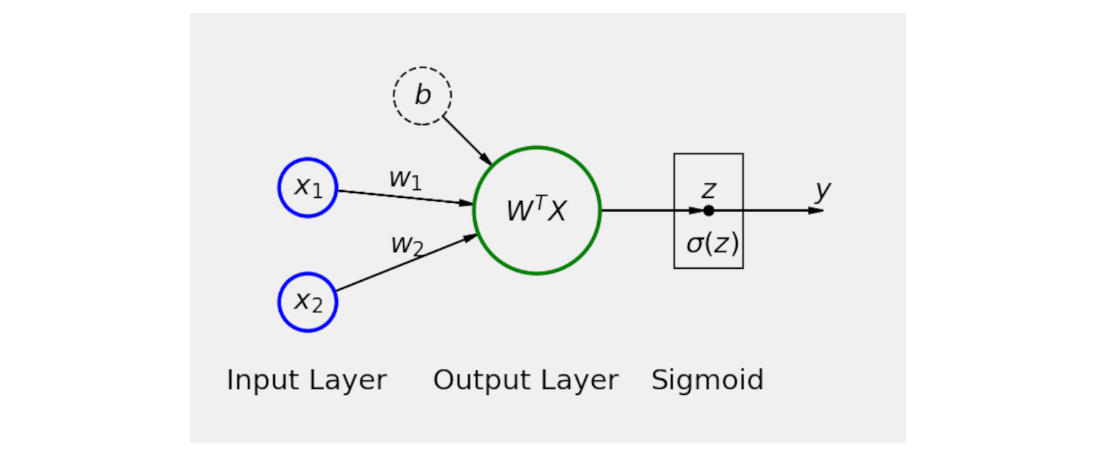

我们可以将逻辑回归视为第二简单的神经网络。它与线性回归几乎相同，但对输出层 (z) 的结果应用了 sigmoid。现在记住这一点，让我们使用 Sequential 模型在 PyTorch 中构建我们的逻辑回归：

In [10]:
torch.manual_seed(42)
model1 = nn.Sequential()
model1.add_module('linear', nn.Linear(2, 1))
model1.add_module('sigmoid', nn.Sigmoid())
print(model1.state_dict())

OrderedDict([('linear.weight', tensor([[0.5406, 0.5869]])), ('linear.bias', tensor([-0.1657]))])


您是否注意到 state_dict 仅包含来自 linear 层的参数？尽管该模型有第二个 sigmoid 层，但该层不包含任何参数，因为它不需要学习任何东西。无论它属于哪个模型，sigmoid 函数都是相同的。

## 关于符号的注释
到目前为止，我们已经处理了一个特征或两个特征。它使我们能够拼出方程式，列出所有术语。但是如果我们开始处理像图像这样的输入，特征的数量很容易增加。所以我们需要就矢量化特征的符号达成一致。实际上，如果你观察上面给出的逻辑回归图，你可以清楚地看到我们已经在那里使用它了。$logits (z)$ 由以下表达式给出：

$z=W^T\cdot X~=~[-~w^T-]~\cdot~\begin{bmatrix}1\\ x_1\\ x_2\\ x_2\\ \end{bmatrix}~=~[b~w_1~w_2]~\cdot\begin{bmatrix}1\\ x_1\\ x_2\\ x_2\\ \end{bmatrix} =b+w_1x_1+w_2x_2 $